<a href="https://colab.research.google.com/github/ori112/minimum-temperature/blob/main/minimum_temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimum temperature time series
##exploring the data

In [65]:
# core libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.model_selection import TimeSeriesSplit ,cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# modeling and evaluating
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [33]:
# reading project file
df = pd.read_csv(r'/content/daily-minimum-temperatures-in-me.csv')

In [34]:
df.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [35]:
# inspecting info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        3650 non-null   object
 1   Daily minimum temperatures  3650 non-null   object
dtypes: object(2)
memory usage: 57.2+ KB


In [36]:
df["Daily minimum temperatures"].unique()

array(['20.7', '17.9', '18.8', '14.6', '15.8', '17.4', '21.8', '20',
       '16.2', '13.3', '16.7', '21.5', '25', '20.6', '24.8', '17.7',
       '15.5', '18.2', '12.1', '14.4', '16', '16.5', '18.7', '19.4',
       '17.2', '15.1', '15.4', '15.3', '21.9', '19.9', '16.6', '16.8',
       '17.1', '15', '13.7', '13.9', '18.3', '22', '22.1', '21.2', '18.4',
       '16.1', '15.7', '18.5', '16.9', '17.5', '17.8', '18.6', '17',
       '14.3', '11.4', '16.3', '11.8', '12.2', '14.7', '11.3', '10.6',
       '11.7', '14.2', '11.2', '8.1', '8', '8.8', '13.4', '10.9', '11',
       '14.5', '18.1', '10', '14.9', '15.9', '13', '7.6', '11.5', '13.5',
       '12.4', '13.2', '13.8', '9', '9.8', '8.9', '7.4', '9.9', '9.3',
       '8.6', '11.9', '14', '12', '10.5', '10.7', '10.1', '5.3', '6.6',
       '8.5', '5.9', '3.2', '2.1', '3.4', '5.4', '9.6', '12.3', '12.6',
       '12.8', '11.6', '5.7', '7.1', '2.5', '3.5', '4.6', '7.7', '10.4',
       '9.2', '6.1', '2.7', '4.3', '6.3', '3.8', '4.4', '4.8', '5.8',
   

In [37]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

df["Daily minimum temperatures"] = pd.to_numeric(df["Daily minimum temperatures"], errors='coerce')

In [38]:
# inspecting info after conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Daily minimum temperatures  3647 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [39]:
df.describe()

,Daily minimum temperatures
count,3647.000000
mean,11.186647
std,4.061671
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


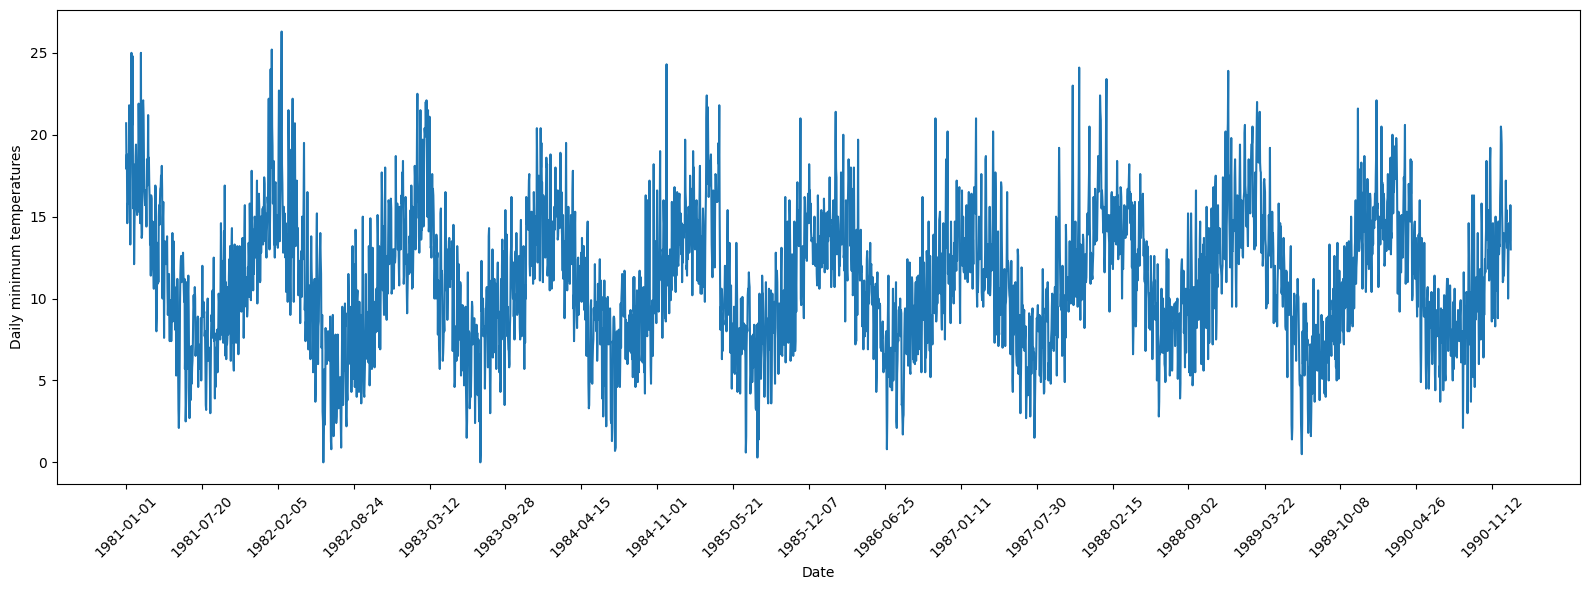

In [40]:
# visualizing the series
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x="Date", y="Daily minimum temperatures")
plt.xticks(ticks=df.index[::200], rotation=45)
plt.tight_layout()
plt.show()

In [41]:
# Extract month-day combination (ignores year)
df['month_day'] = df.index.strftime('%m-%d')

# Compute average per day across years
daily_avg = df.groupby("month_day")["Daily minimum temperatures"].transform("mean")

# Impute NaNs using historical daily average
df["Daily minimum temperatures"].fillna(daily_avg, inplace=True)

# Drop the helper column if needed
df.drop(columns="month_day", inplace=True)


<ipython-input-41-3688153917>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Daily minimum temperatures"].fillna(daily_avg, inplace=True)


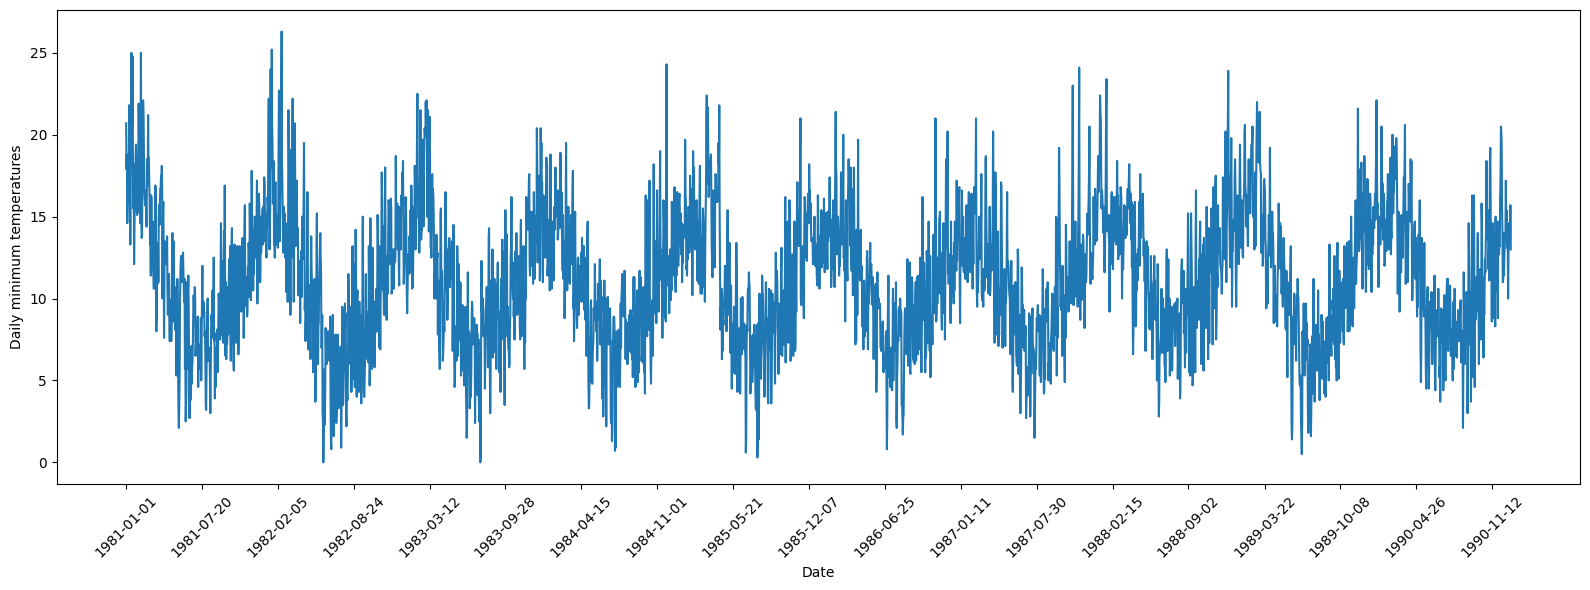

In [42]:
# visualizing the series
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x="Date", y="Daily minimum temperatures")
plt.xticks(ticks=df.index[::200], rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

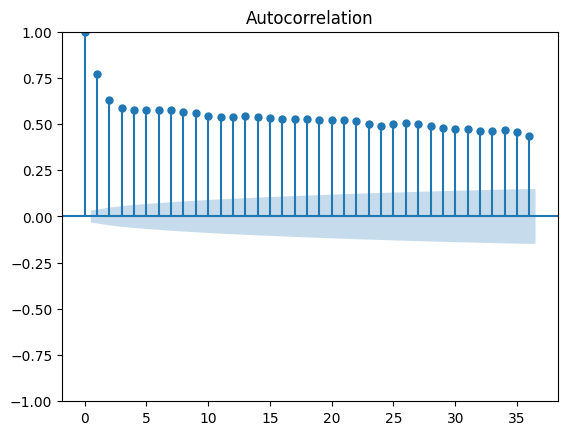

In [43]:
plt.figure(figsize=(12,6))
plot_acf(df["Daily minimum temperatures"])
plt.show()

<Figure size 1200x600 with 0 Axes>

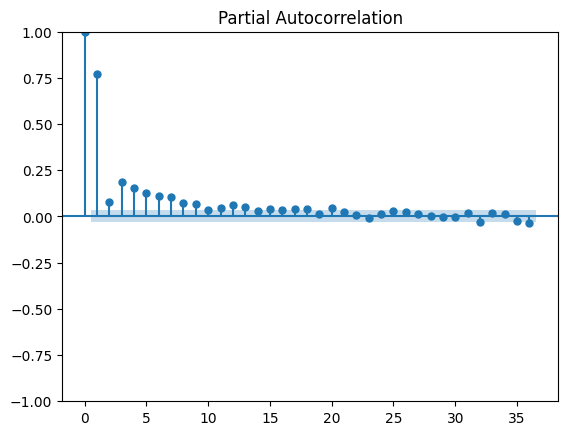

In [44]:
plt.figure(figsize=(12,6))
plot_pacf(df["Daily minimum temperatures"])
plt.show()

<Figure size 640x480 with 0 Axes>

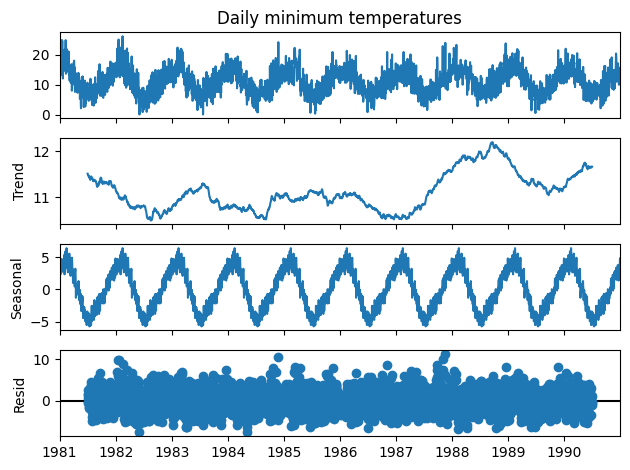

In [45]:
decompose = seasonal_decompose(df["Daily minimum temperatures"], model='additive', period=365)

plt.figure()
decompose.plot()
plt.show()

In [46]:
result = adfuller(df["Daily minimum temperatures"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -4.428392206400444
p-value: 0.00026430990761959873


In [47]:
df_weekly = df.resample('W').mean()
df_weekly.head()

,Daily minimum temperatures
Date,
1981-01-04,18.000000
1981-01-11,17.542857
1981-01-18,20.371429
1981-01-25,15.771429
1981-02-01,16.657143


## preprocessing and modeling the data

In [55]:
train_size = int(len(df_weekly) * 0.8)
train = df_weekly.iloc[:train_size]["Daily minimum temperatures"]
test = df_weekly.iloc[train_size:]["Daily minimum temperatures"]

In [69]:
model = SARIMAX(
    df_weekly,
    order=(1, 0, 1),              # No differencing (d=0) since ADF says stationary
    seasonal_order=(1, 1, 1, 52), # Now seasonal period is 52 weeks
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:         Daily minimum temperatures   No. Observations:                  523
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood                -834.858
Date:                            Fri, 13 Jun 2025   AIC                           1679.716
Time:                                    09:55:58   BIC                           1699.881
Sample:                                01-04-1981   HQIC                          1687.688
                                     - 01-06-1991                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7940      0.088      9.022      0.000       0.622       0.966
ma.L1         -0.6131      0.110   

In [70]:
# Forecast on test set
forecast = results.get_forecast(steps=len(test)).predicted_mean

rmse = np.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)

print(f"Model — RMSE: {rmse:.2f}, R²: {r2:.3f}")

Model — RMSE: 1.65, R²: 0.784


In [71]:
residuals = results.resid

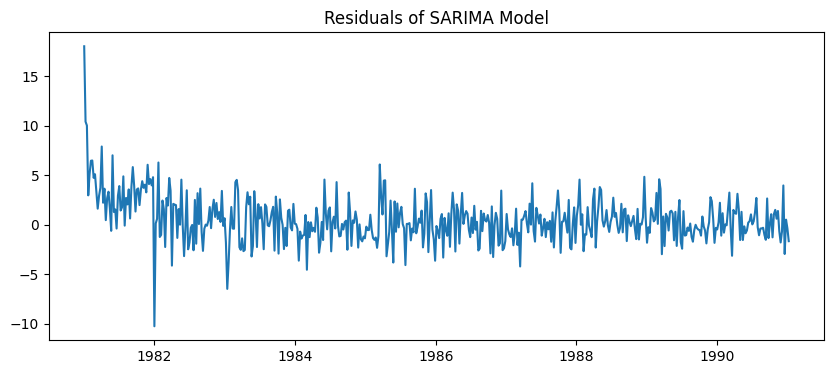

In [72]:
# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.show()

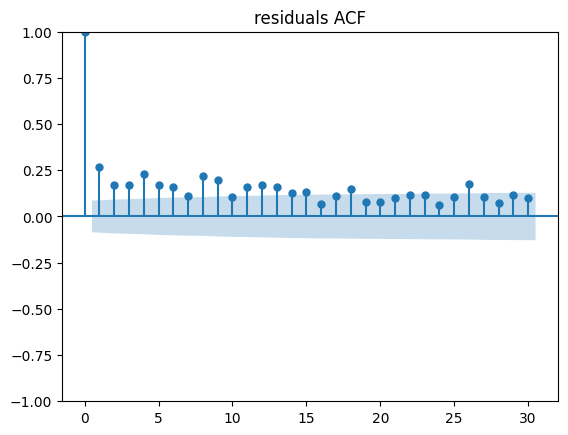

In [73]:
plot_acf(residuals, lags=30)
plt.title("residuals ACF")
plt.show()

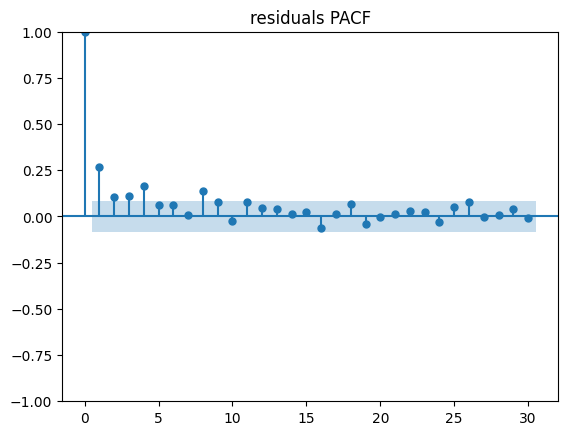

In [74]:
plot_pacf(residuals, lags=30)
plt.title("residuals PACF")
plt.show()

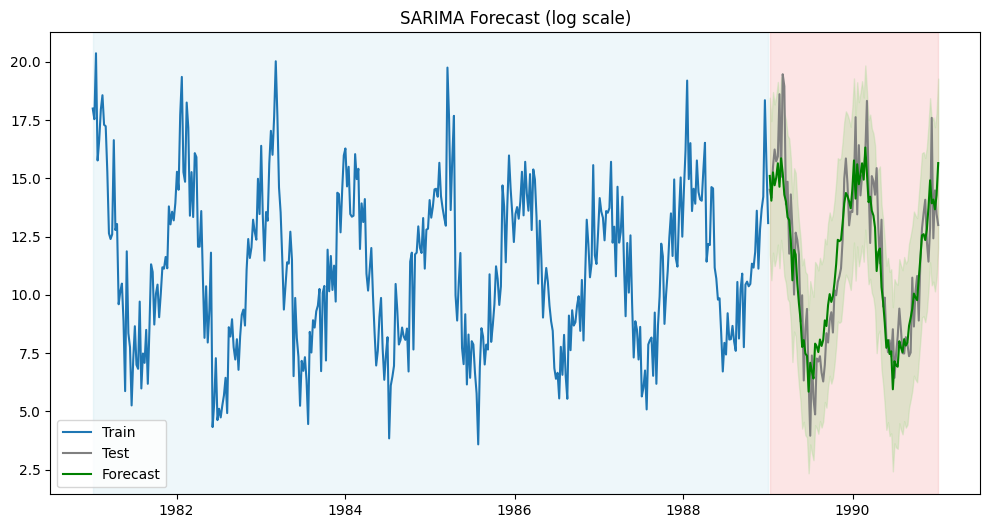

In [84]:
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='gray')
plt.plot(test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.3)
plt.axvspan(test.index[0], test.index[-1], color='lightcoral', alpha=0.2)
plt.axvspan(train.index[0], train.index[-1], color='lightblue', alpha=0.2)
plt.title("SARIMA Forecast (log scale)")
plt.legend()
plt.show()